### Intracellular Ca signalling model

1. Markov state modeling was built based on "Allosteric Regulation of the P2X4 Recepter Channel Pore Dilation" by Zemkova, Khadra, Rokic, Tvrdonova, Sherman, and Stojikovic.

- This is 13 state models

2. The relative contribution of Ca to total inward current in the cell (HEK293) was reported to be 8.24 +- 0.36% by Garcia-Guzman. -> This may need to be adjusted for rat P2X4 channel
3. The diameter of HEK293 cell body is approximated to be 13 microns -> r = 6.5 microns
4. The diameter of microglia cell body is approximated to be 5.2 microns -> r = 2.6 microns (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4213482/)
5. Beyond the buffering effects of calmodulin was handled by Rachel
6. The intermediate product of this code is "intracellular Ca transient"
7. The final outcome of this code is "TNF-alpha transient"


#### Limitations & Assumptions

1. NFAT terms with no detail connection to buffering effects.

2. No TNF terms

#### NFATNn Profile & TNF-alpha release

1. Even after adjusting some of parameters, there is no supporting data to explain or indicating the scale of concentrations. 
2. The pattern of profile will be used as a switch of TNF-alpha release and the concentration of NFATNn will not influence on the degree of release
3. The release of TNF-alpha will be fully assumed based on general RNA transcription and translation. https://www.mathworks.com/help/simbio/gs/-model-a-gene-regulation-pathway.html?requestedDomain=true

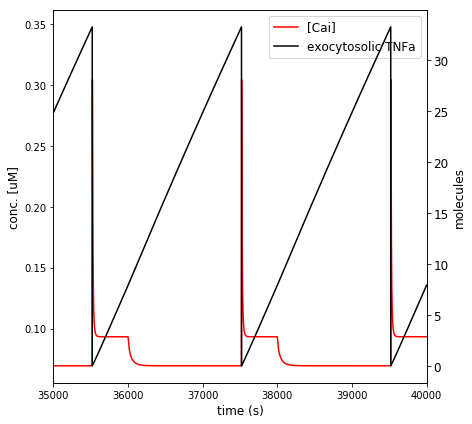

In [6]:
plots(total(480,20,10,2000,10),12,6,35000,40000) # total(st,Du,step,interval,ATP)

In [5]:
# Function for integreating ODE and displaying results
import scipy.integrate
from scipy.integrate import odeint
import numpy as np
import matplotlib.pylab as plt
import math
from math import exp
from scipy.interpolate import spline
%matplotlib inline

# Importing the microglia related packages
import data as dt      # Data sorting code
import TNFa as ta      # TNFa release code
import NFAT as nt      # NFAT cycle code
import MSMp2x4 as p4   # Markov State Model for P2X4 channel
import SBbuffers as bf # Buffers (Fura-2, Calmodulin, and Calsequestrin) code
import SERCAER as er   # SERCA Pump code
import NCX as nx       # Na/Ca exchanger code

import numpy.random as npr
# normal random distribution
from numpy.random import normal as nprn
# uniform random distribution
from numpy.random import uniform as npru

def ft(y,t,A):
    # Assigning the variables from the initial input y(array)
    Cai, CaM, CaF, CaS, CaER, D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_release = y
    
    # Basic Condition & Constant
    T = 310 # [K] Temp
    
    # P2X4 Markov State 
    ip2x4 = np.array([D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N, A])    
    dD1dt, dD2dt, dD3dt, dD4dt, dC1dt, dC2dt, dC3dt, dC4dt, dQ1dt, dQ2dt, dQ3dt, dQ4dt, dNdt = p4.fp2x4(ip2x4)
    
    # Ca influx via P2X4
    iJp2x4 = np.array([Q1, Q2, Q3, Q4])
    Jp2x4 = p4.fJp2x4(iJp2x4)
    
    # SERCA Term
    iJsercaER = np.array([Cai, CaER, T])   
    JERtoCyt, JCyttoER = er.fJsercaER(iJsercaER)
    
    # Buffer Term
    ibuff = np.array([Cai, CaM, CaF, CaER, CaS])
    dCaMdt, dCaFdt, dCaSdt = bf.fbuff(ibuff)
    
    # NCX Term
    iJNCX = np.array([Cai,T])
    JNCX = nx.fNCX(iJNCX)
    
    # NFAT Cycle
    iNFAT = np.array([Cai, CaM, NFATpc, NFATpn, NFATNc, NFATNn])
    dNFATpcdt, dNFATpndt, dNFATNcdt, dNFATNndt = nt.fNFAT(iNFAT)
    
    # TNFa release
    iTNFa = np.array([NFATNn, Cai, DNA, DNA_TNF, mRNA, TNFa, TNFa_release])
    dDNAdt, dDNATNFdt, dRNAdt, dTNFadt, dTNFa_releasedt = ta.fTNFa(iTNFa)
    
    # Calcium concentration in cytosol and ER 
    ##################################################################
    dCaidt = - dCaMdt - dCaFdt - JCyttoER + Jp2x4 + JNCX
    dCaERdt = JERtoCyt - dCaSdt
    #####################################################################################################
    
    dydt = [dCaidt, dCaMdt, dCaFdt, dCaSdt, dCaERdt, 
            dD1dt, dD2dt, dD3dt, dD4dt, 
            dC1dt, dC2dt, dC3dt, dC4dt, 
            dQ1dt, dQ2dt, dQ3dt, dQ4dt, dNdt, 
            dNFATpcdt, dNFATpndt, dNFATNcdt, dNFATNndt,
            dDNAdt, dDNATNFdt, dRNAdt, dTNFadt, dTNFa_releasedt]
        
    return dydt

def total(st,Du,step,interval,ATP):
    # st : ATP stimulation time in second
    # Du : Total running time in second
    # step : step size in linspace
    # interval : time between stimulation 
    # ATP = [ATP] in uM
    
    d0 = dt.data0()
       
    iters = np.arange(Du)
    
    for i in iters:

        ti = i*interval          # 0, 30, 60, 90 .... 
        tf = (i+1)*interval-st   # 28, 58, 88, 118 ....
        
        trs = scipy.linspace(ti,tf,(interval*step))  # time without ATP stimulation
        tst = scipy.linspace(tf,(tf+st),(st*step))  # time with ATP stimulation
        
        if i == 0 : # Very first step of calculation
            A = 0   # Turn off the ATP concentration
            Cai0 = 6.94117906963e-08    # [M]
            CaM0 = 2.35646617669e-07    # [M]
            CaF0 = 7.7904949838e-06     # [M]
            CaS0 = 0.00067938125894     # [M]
            CaER0 = 0.000479675025373   # [M]
            NFATpc0 = 0.994682667758    # [nM]
            NFATpn0 = 0.0463772043925   # [nM]
            NFATNc0 = 0.000112322167638 # [nM]
            NFATNn0 = 0.0581439005689   # [nM]
            dst = d0
            y0 = np.array([Cai0, CaM0, CaF0, CaS0, CaER0,
                           0, 0, 0, 0,
                           1, 0, 0, 0,
                           0, 0, 0, 0, 0,
                           NFATpc0, NFATpn0, NFATNc0, NFATNn0,
                           50,0,0,100,0]) # Very first step
        else :            
            y0 = np.array([Cai[-1], CaM[-1], CaF[-1], CaS[-1], CaER[-1],
                           D1[-1], D2[-1], D3[-1], D4[-1],
                           C1[-1], C2[-1], C3[-1], C4[-1],
                           Q1[-1], Q2[-1], Q3[-1], Q4[-1], N[-1],
                           NFATpc[-1], NFATpn[-1], NFATNc[-1], NFATNn[-1],
                           DNA[-1],DNA_TNF[-1],mRNA[-1],TNFa[-1],TNFa_release[-1]]) 
        
        # Solving for the resting state
        A = 0 # Turn off the ATP concentration
        yrs = scipy.integrate.odeint(ft,y0,trs,args=(A,))
        # Storing the data from the resting state calculation
        drs = dt.data(dst,yrs,trs)
        Cai, CaM, CaF, CaS, CaER, D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_release, time = drs
        
        del y0
        del A
        del yrs
        del trs
        
        # Solving for the stimulated state
        A = ATP*10**-6    # ATP uM ATP stimulation
        y0 = np.array([Cai[-1], CaM[-1], CaF[-1], CaS[-1], CaER[-1],
                       D1[-1], D2[-1], D3[-1], D4[-1],
                       C1[-1], C2[-1], C3[-1], C4[-1],
                       Q1[-1], Q2[-1], Q3[-1], Q4[-1], N[-1],
                       NFATpc[-1], NFATpn[-1], NFATNc[-1], NFATNn[-1],
                       DNA[-1],DNA_TNF[-1],mRNA[-1],TNFa[-1],0])
        yst = scipy.integrate.odeint(ft,y0,tst,args=(A,))
    
        dst = dt.data(drs,yst,tst)
        Cai, CaM, CaF, CaS, CaER, D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_release, time = dst
        
        del yst
        del tst
        del ti 
        del tf 
        
    results = [Cai, CaM, CaF, CaS, CaER, D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_release, time]
    
    return results

def plots(results,width,height,xlimlow,xlimhigh):
    Cai, CaM, CaF, CaS, CaER, D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_release, time = results
    conv_MtouM = 10**6
    Cai = Cai*conv_MtouM
    
    ##################################################
    #plt.figure(figsize=(width,height))
    #plt.subplot(1,2,1)
    #plt.tick_params(labelsize=12)
    #plt.plot(time,Cai,'r-',label="[Ca]i")
    #plt.xlabel("time (s)",fontsize=12)
    #plt.ylabel("conc. [uM]",fontsize=12)
    #plt.legend(loc=0,fontsize=12)
    #plt.xlim(xlimlow,xlimhigh)
    #plt.tight_layout()
    ##################################################
    #ax = plt.subplot(1,2,2)
    #ax2 = ax.twinx()
    #plt.tick_params(labelsize=12)
    #lns1 = ax.plot(time,Cai,'r-',label="[Ca]i")
    #lns2 = ax2.plot(time,NFATNn,'b-',label="[NFATNn]")

    #ax.set_xlabel("time (s)",fontsize=12)
    #ax.set_ylabel("conc. [uM]",fontsize=12)
    #ax2.set_ylabel("conc. [nM]",fontsize=12)
    
    #lns = lns1+lns2
    #labs = [l.get_label() for l in lns]
    #ax.legend(lns, labs, loc=0, fontsize=12)
    #plt.xlim(xlimlow,xlimhigh)
    #plt.tight_layout()
    ##################################################
    #plt.figure(figsize=(width,height))
    #plt.subplot(1,2,1)
    #plt.tick_params(labelsize=12)
    #plt.plot(time,NFATpc,'b-',label="[NFATpc]")
    #plt.plot(time,NFATpn,'k.-',label="[NFATpn]")
    #plt.plot(time,NFATNc,'g-',label="[NFATNc]")
    #plt.plot(time,NFATNn,'r.-',label="[NFATNn]")
    #plt.xlabel("time (s)",fontsize=12)
    #plt.ylabel("conc. [nM]",fontsize=12)
    #plt.legend(loc=0,fontsize=12)
    #plt.xlim(xlimlow,xlimhigh)
    #plt.tight_layout()
    ##################################################
    #plt.subplot(1,2,2)
    #plt.tick_params(labelsize=12)
    #plt.plot(time,TNFa,'k--',label="TNFa in nucleus")
    #plt.xlabel("time (s)",fontsize=12)
    #plt.ylabel("molecules",fontsize=12)
    #plt.legend(loc=0,fontsize=12)
    #plt.xlim(xlimlow,xlimhigh)
    #plt.ylim(14,18)
    #plt.tight_layout()
    ##################################################
    #plt.figure(figsize=(width,height))
    #ax = plt.subplot(1,2,1)
    #ax2 = ax.twinx()
    #plt.tick_params(labelsize=12)
    
    #lns1 = ax.plot(time,TNFa,'k--',label="TNFa in nucleus")
    #lns2 = ax2.plot(time,NFATNn,'r-',label="[NFATNn]")
    #lns = lns1 + lns2
    #labs = [l.get_label() for l in lns]
    #ax.legend(lns,labs,loc=0, fontsize=12)
    
    #ax.set_xlabel("time (s)",fontsize=12)
    #ax.set_ylabel("molecules",fontsize=12)
    #ax2.set_ylabel("conc. [nM]",fontsize=12)
    #ax.set_ylim(14,18)
    #plt.xlim(xlimlow,xlimhigh)
    #plt.tight_layout()
    ##################################################
    #plt.subplot(1,2,2)
    #plt.tick_params(labelsize=12)
    #plt.plot(time,DNA,label="DNA")
    #plt.plot(time,DNA_TNF,label="DNA-TNF complex")
    #plt.plot(time,mRNA,label="mRNA")
    #plt.plot(time,TNFa,label="TNFa in nucleus")
    #plt.plot(time,TNFa_release,label="exocytosolic TNFa")
    #plt.xlabel("time (s)",fontsize=12)
    #plt.ylabel("molecules",fontsize=12)
    #plt.xlim(xlimlow,xlimhigh)
    #plt.ylim(0,55)
    #plt.legend(loc=0,fontsize=12)
    #plt.tight_layout()
    ##################################################
    plt.figure(figsize=(width,height))
    ax = plt.subplot(1,2,1)
    ax2 = ax.twinx()
    plt.tick_params(labelsize=12)
    lns1 = ax.plot(time,Cai,'r-',label="[Cai]")
    lns2 = ax2.plot(time,TNFa_release,'k-',label="exocytosolic TNFa")
    ax.set_xlabel("time (s)",fontsize=12)
    ax.set_ylabel("conc. [uM]",fontsize=12)
    ax2.set_ylabel("molecules",fontsize=12)
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns,labs,loc=0, fontsize=12)
    plt.xlim(xlimlow,xlimhigh)

    plt.tight_layout()

    return

In [16]:
def ATPvsTNF():
    ATPrange = [0.001,1,5,10,100,1000] # [uM]
    eTNFa = [] # released TNFa at steady state in [molecule]
    rTNFa = [] # released TNFa at steady state percent
    for A in ATPrange:
        dummy = []
        results = total(480,20,10,2000,A)
        Cai, CaM, CaF, CaS, CaER, D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N, NFATpc, NFATpn, NFATNc, NFATNn, DNA, DNA_TNF, mRNA, TNFa, TNFa_release, time = results
        iters = np.arange(np.shape(time)[0])
        for i in iters:
            if time[i] >= 30000 and time[i] < 40000:
                dummy = np.append(dummy,TNFa_release[i])
        dummy2 = max(dummy)
        eTNFa = np.append(eTNFa,dummy2)
        dummy = None
        dummy2 = None
    
    TNFaMax = max(eTNFa)
    for T in eTNFa:
        rTNFa = np.append(rTNFa,(T/TNFaMax)*100)
    
    plt.figure(figsize=(7,7))
    plt.semilogx(ATPrange, rTNFa, 'k-.')
    plt.xlabel("ATP [uM]")
    plt.ylabel("% TNFa")
    plt.title('ATP conc. vs. TNFa')
    #plt.grid(True)
    
    #plt.figure(figsize=(7,7))
    #objects = ('1 uM', '5 uM', '7.5 uM', '10 uM', '0.1 mM', '0.2 mM', '1 mM')
    #y_pos = np.arange(len(objects))
    #plt.bar(y_pos, rTNFa, align='center', alpha=0.5)
    #plt.xticks(y_pos, objects)
    #plt.ylabel('TNFa release (% of 1 mM)')
    
    
    return eTNFa



/home/AD/bch265/Dropbox/Postdoctoral2017-/Modeling-Codes/Microglia/compartments/SERCAER.py:30: RuntimeWarning: invalid value encountered in double_scalars
  JERtoCyt = QERCa*VmaxSERCA*(((Cai/Kmf)**H)-((CaER/Kmr)**H))/(1+((Cai/Kmf)**H)+((CaER/Kmr)**H))


Text(0,0.5,'TNFa release (% of 1 mM)')

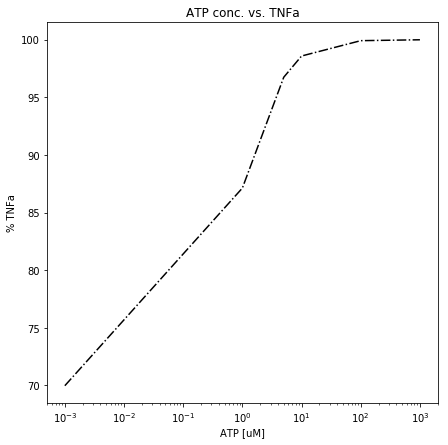

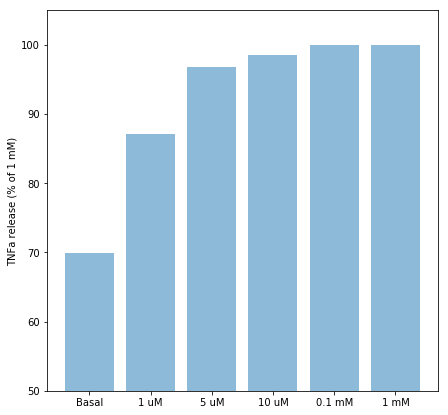

In [20]:
rTNFa = []
eTNFa = ATPvsTNF()
TNFaMax = max(eTNFa)

for T in eTNFa:
    rTNFa = np.append(rTNFa,(T/TNFaMax)*100)

plt.figure(figsize=(7,7))
objects = ('Basal','1 uM', '5 uM', '10 uM', '0.1 mM', '1 mM')
y_pos = np.arange(len(objects))
plt.bar(y_pos, rTNFa, align='center', alpha=0.5)
plt.ylim(50,105)
plt.xticks(y_pos, objects)
plt.ylabel('TNFa release (% of 1 mM)')
